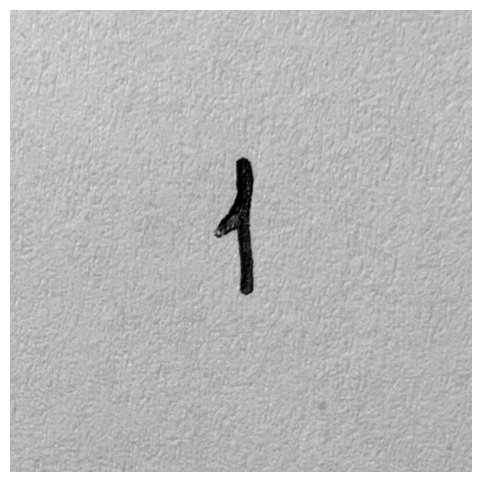

shape: (800, 800)
min: 0.0
max: 0.9603


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

original_image = mpimg.imread('images/1.png')
original_grey = np.dot(original_image[..., :3], [0.2989, 0.5870, 0.1140])
image = np.dot(original_image[..., :3], [0.2989, 0.5870, 0.1140])

plt.figure(figsize=(6, 6))

plt.imshow(original_grey, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

print(f'shape: {original_grey.shape}')
print(f'min: {round(original_grey.min(), 4)}')
print(f'max: {round(original_grey.max(), 4)}')

In [2]:
# valor más repetido
def mas_repetido(image, value=None, delta=None):   # value: 'min' | 'max'
    minimo = image.min()
    maximo = image.max()
    
    if value == None:
        valores, conteos = np.unique(image, return_counts=True)
        rep = valores[np.argmax(conteos)]
        return rep
    elif value == 'min':   # min: mas oscuros
        rango_min = minimo + delta
        rango = image[(image >= minimo) & (image <= rango_min)]
        valores, conteos = np.unique(rango, return_counts=True)
        rep = valores[np.argmax(conteos)]
        return rep
    elif value == 'max':   # min: mas claros
        rango_max = maximo - delta
        rango = image[(image <= maximo) & (image >= rango_max)]
        valores, conteos = np.unique(rango, return_counts=True)
        rep = valores[np.argmax(conteos)]
        return rep
    
# Detectar si es similar a rep
def rep_to_color(valor, rep, delta):
    if abs(valor - rep) <= delta: return True
    else: return False

# cambiar color mas oscuro y mas repetido (texto) a negro
def toBlack(image, delta1, delta2):
    rep = mas_repetido(image, 'min', delta1)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if rep_to_color(image[i, j], rep, delta2):
                image[i, j] = 0
    return image

# suponiendo que todos los oscuros ya se convirtieron a 0, convertir todo el resto en 1
def toWhite(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] != 0:
                image[i, j] = 1
    return image

# definir tono actual
def tono(valor, delta, min_rep, max_rep):
    if abs(valor - min_rep) <= delta: return 0
    elif abs(valor - max_rep) <= delta: return 1

#### Convertir a blanco y negro

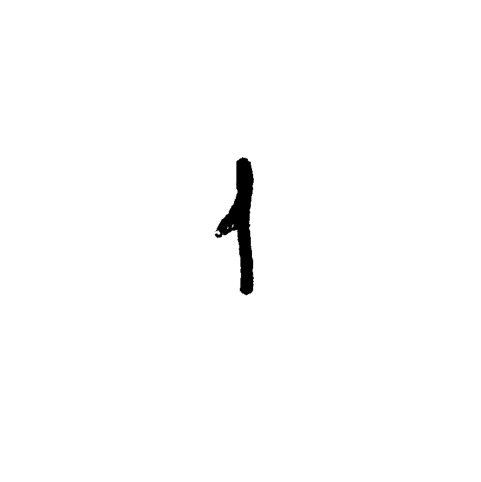

In [3]:
image = toBlack(image, 0.05, 0.4)
image = toWhite(image)

plt.figure(figsize=(6, 6))

plt.imshow(image, cmap='gray',vmin=0, vmax=1)
plt.axis('off')

plt.show()

#### Borders

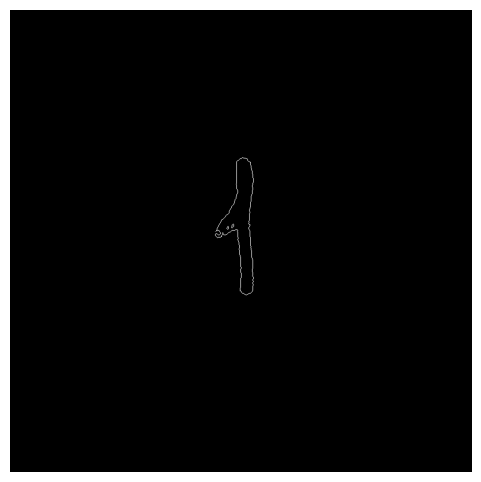

In [4]:
border_mask = np.zeros(image.shape)

min_rep = mas_repetido(image, 'min', 0.1)
max_rep = mas_repetido(image, 'max', 0.1)

delta = 0.05
delta1 = 0.05

# izquierda -> derecha | arriba -> abajo
for i in range(image.shape[0]):
    for j in range(image.shape[1] - 1):
        tono_actual = tono(image[i,j], delta1, min_rep, max_rep)
        if abs(image[i,j] - image[i,j+1]) > delta:
            if tono_actual == 1:
                border_mask[i,j+1] = 1
            elif tono_actual == 0:
                border_mask[i,j] = 1
                
# arriba -> abajo | izquierda -> derecha
for j in range(image.shape[1]):
    for i in range(image.shape[0] - 1):
        tono_actual = tono(image[i,j], delta1, min_rep, max_rep)
        if abs(image[i,j] - image[i+1,j]) > delta:
            if tono_actual == 1:
                border_mask[i+1,j] = 1
            elif tono_actual == 0:
                border_mask[i,j] = 1
                
plt.figure(figsize=(6, 6))

plt.imshow(border_mask, cmap='gray',vmin=0, vmax=1)
plt.axis('off')

plt.show()

#### Mejorar imperfecciones: square-radius code

In [5]:
def vecinos(image, coord, R):
    vecinos = []
    i = coord[0]
    j = coord[1]
    down_lim = image.shape[0] - 1
    left_lim = image.shape[1] - 1
    
    # filas arriba
    for r in range(R, 0, -1):
        if i - r >= 0:
            for rr in range (R, 0, -1):
                if j - rr >= 0:
                    vecinos.append(image[i-r, j-rr])
            vecinos.append(image[i-r, j])
            for rr in range(1, R+1):
                if j + rr <= left_lim:
                    vecinos.append(image[i-r, j+rr])
    
    # misma fila                
    for r in range(R, 0, -1):
        if j - r >= 0:
            vecinos.append(image[i, j-r])
    for r in range(1, R+1):
        if j + r <= left_lim:
            vecinos.append(image[i, j+r])
            
    # filas abajo
    for r in range(1, R+1):
        if i + r <= down_lim:
            for rr in range (R, 0, -1):
                if j - rr >= 0:
                    vecinos.append(image[i+r, j-rr])
            vecinos.append(image[i+r, j])
            for rr in range(1, R+1):
                if j + rr <= left_lim:
                    vecinos.append(image[i+r, j+rr])
                
    return np.array(vecinos)

In [6]:
def porcentaje_black_vecinos(image, r, p):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            vecinos_lst = vecinos(image, (i, j), r)
            if image[i, j] == 1:
                porcentaje = len(vecinos_lst[vecinos_lst == 0]) / len(vecinos_lst)
                if porcentaje >= p:
                    image[i, j] = 0
    return image

def porcentaje_white_vecinos(image, r, p):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            vecinos_lst = vecinos(image, (i, j), r)
            if image[i, j] == 0:
                porcentaje = len(vecinos_lst[vecinos_lst == 1]) / len(vecinos_lst)
                if porcentaje >= p:
                    image[i, j] = 1
    return image

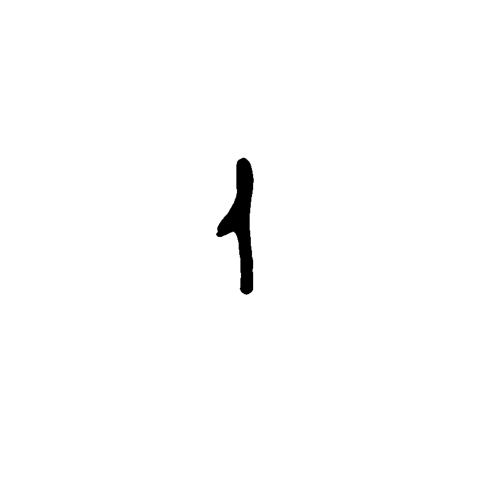

In [7]:
image = porcentaje_black_vecinos(image, 6, 0.51)
image = porcentaje_white_vecinos(image, 4, 0.51)

plt.figure(figsize=(6, 6))

plt.imshow(image, cmap='gray',vmin=0, vmax=1)
plt.axis('off')

plt.show()

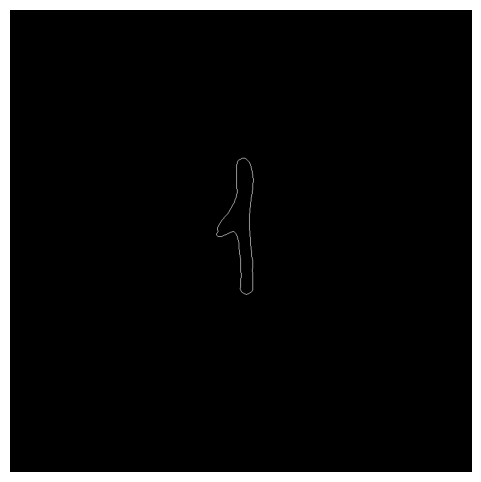

In [8]:
border_mask = np.zeros(image.shape)

min_rep = mas_repetido(image, 'min', 0.1)
max_rep = mas_repetido(image, 'max', 0.1)

delta = 0.05
delta1 = 0.05

# izquierda -> derecha | arriba -> abajo
for i in range(image.shape[0]):
    for j in range(image.shape[1] - 1):
        tono_actual = tono(image[i,j], delta1, min_rep, max_rep)
        if abs(image[i,j] - image[i,j+1]) > delta:
            if tono_actual == 1:
                border_mask[i,j+1] = 1
            elif tono_actual == 0:
                border_mask[i,j] = 1
                
# arriba -> abajo | izquierda -> derecha
for j in range(image.shape[1]):
    for i in range(image.shape[0] - 1):
        tono_actual = tono(image[i,j], delta1, min_rep, max_rep)
        if abs(image[i,j] - image[i+1,j]) > delta:
            if tono_actual == 1:
                border_mask[i+1,j] = 1
            elif tono_actual == 0:
                border_mask[i,j] = 1
                
plt.figure(figsize=(6, 6))

plt.imshow(border_mask, cmap='gray',vmin=0, vmax=1)
plt.axis('off')

plt.show()